In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [5]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

C:\Users\zhhua\AppData\Local\Temp\ipykernel_8792\498919690.py:66: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mask.astype(np.bool), class_ids.astype(np.int32)


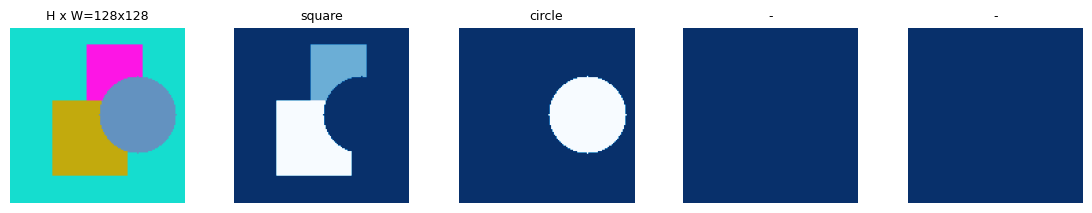

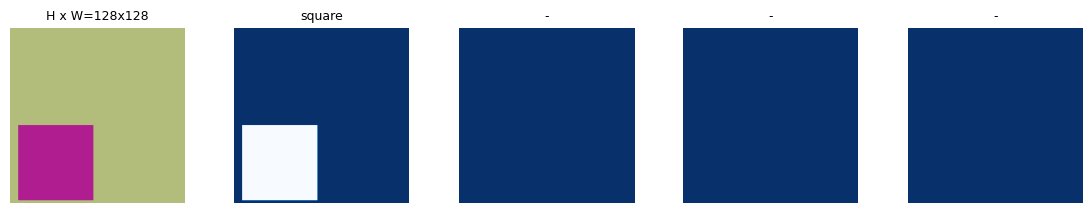

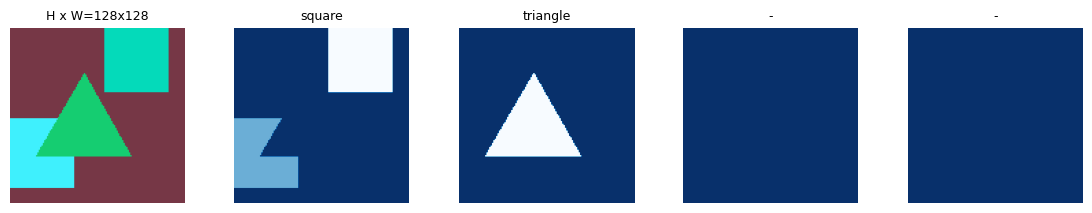

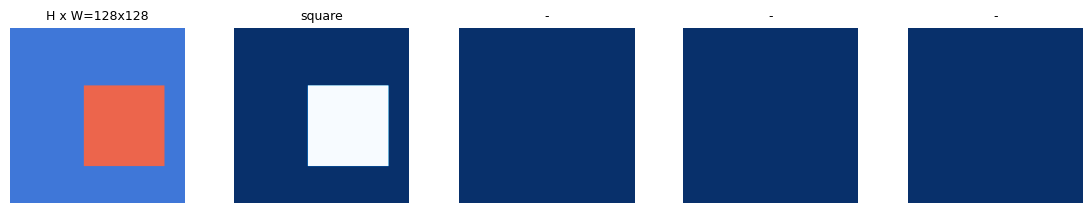

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

x: Tensor("roi_align_classifier/truediv_1:0", shape=(8, None, 1), dtype=float32)
s: (8, None, 16)
x: Tensor("roi_align_mask/truediv_1:0", shape=(8, None, 1), dtype=float32)
---------------------debug model built


In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [9]:
import warnings
warnings.filterwarnings('ignore')
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\zhhua\OneDrive\Desktop\PythonProgram\CAT\logs\shapes20230616T0825\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistri

In [10]:
import tensorflow as tf
import numpy as np

# Define your loss computation function
def compute_loss(y_true, y_pred):
    # Your loss computation logic here
    loss = tf.reduce_mean(tf.square(y_true - y_pred))
    print('loss.op: %s' % loss.op)
    print('loss: %s' % loss)
    return loss

# Wrap the loss computation in a lambda function
loss_fn = lambda y_true, y_pred: compute_loss(y_true, y_pred)

# Create a TensorFlow model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))

model.add_loss(loss_fn)

# Compile the model with the wrapped loss function
model.compile(optimizer='adam')

# Train the model
x_train = np.random.randn(100, 10)
y_train = np.random.randn(100, 1)
model.fit(x_train, y_train, epochs=10, batch_size=32)


In [12]:
x_train

array([[-1.18777619e+00,  1.30488988e+00,  1.09382473e+00,
         1.51118445e+00,  1.10552630e+00, -2.81244264e-02,
        -1.08085147e-02, -8.95567574e-01, -1.43122023e+00,
         9.64998717e-01],
       [ 8.78235816e-01, -1.56128173e-01,  2.19151350e-01,
         1.58662075e-01, -1.23398378e+00, -8.05015097e-02,
        -1.64321875e-01,  1.14869232e+00, -8.41574424e-01,
         6.02422782e-01],
       [ 7.33041775e-01, -9.16783807e-01,  1.21501921e+00,
        -2.03506151e-01, -6.21335142e-01, -2.01996950e+00,
        -1.06981988e+00, -5.75004488e-01, -4.80738719e-01,
        -1.46983716e+00],
       [ 1.71270842e+00,  4.01543465e-01,  1.33461257e-01,
        -1.17156029e+00,  3.05964002e-01, -1.23271661e+00,
        -1.72634868e+00,  1.03553136e+00, -1.54330071e+00,
         1.39993875e+00],
       [-9.27117649e-01, -3.61054572e-01,  1.08099447e-01,
         6.63228987e-01,  1.60552023e+00, -1.30104890e+00,
        -6.71559426e-01, -5.92519258e-01, -1.45971721e+00,
         2.

In [ ]:
tf.add_n()

In [ ]:
node_def: name: "Placeholder"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
    }
  }
}


node_def type: <class 'tensorflow.core.framework.node_def_pb2.NodeDef'>

self: FuncGraph(name=add_loss_2_scratch_graph, id=1957637421760)

self type: <class 'tensorflow.python.framework.func_graph.FuncGraph'>

inputs: []

inputs type: <class 'list'>

dtypes: None

dtypes type: <class 'NoneType'>

control_inputs: []

control_inputs type: <class 'list'>

self._default_original_op: None

self._default_original_op type: <class 'NoneType'>

op_def: name: "Placeholder"
output_arg {
  name: "output"
  type_attr: "dtype"
}
attr {
  name: "dtype"
  type: "type"
}
attr {
  name: "shape"
  type: "shape"
  default_value {
    shape {
      unknown_rank: true
    }
  }
}


op_def type: <class 'tensorflow.core.framework.op_def_pb2.OpDef'>

ret: name: "Placeholder"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
    }
  }
}

node_def: name: "Placeholder"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
    }
  }
}


node_def type: <class 'tensorflow.core.framework.node_def_pb2.NodeDef'>

self: FuncGraph(name=add_loss_2_scratch_graph, id=1957637421760)

self type: <class 'tensorflow.python.framework.func_graph.FuncGraph'>

inputs: []

inputs type: <class 'list'>

dtypes: None

dtypes type: <class 'NoneType'>

control_inputs: []

control_inputs type: <class 'list'>

self._default_original_op: None

self._default_original_op type: <class 'NoneType'>

op_def: name: "Placeholder"
output_arg {
  name: "output"
  type_attr: "dtype"
}
attr {
  name: "dtype"
  type: "type"
}
attr {
  name: "shape"
  type: "shape"
  default_value {
    shape {
      unknown_rank: true
    }
  }
}


op_def type: <class 'tensorflow.core.framework.op_def_pb2.OpDef'>

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Input layer
inputs = Input(shape=(10,))

# Hidden layer
x = Dense(32, activation='relu')(inputs)

# Output layer
outputs = Dense(1)(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Custom loss function
def custom_loss(y_true, y_pred):
    # Compute the custom loss
    loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return loss

# Add the custom loss to the model
print(custom_loss(inputs, outputs))


KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.reduce_mean_2/Mean:0', description="created by layer 'tf.math.reduce_mean_2'")


In [11]:
print(inputs)

KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [10]:
import tensorflow as tf
import numpy as np

# Create a tensor from a Python list
tensor = tf.convert_to_tensor([1, 2, 3])

# Create a tensor from a NumPy array
array = np.array([1, 2, 3])
tensor = tf.convert_to_tensor(array)
tensor

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3])>

In [23]:
y_true = [None, None, None, None, None, None, None, None, None, None, None, None, None, None]
y_pred = ["<tf.Tensor 'mask_rcnn/rpn_class_logits/concat:0' shape=(None, None, 2) dtype=float32>", "<tf.Tensor 'mask_rcnn/rpn_class/concat:0' shape=(None, None, 2) dtype=float32>", "<tf.Tensor 'mask_rcnn/rpn_bbox/concat:0' shape=(None, None, 4) dtype=float32>", "<KerasTensor: shape=(8, None, 4) dtype=float32 (created by layer 'mrcnn_class_logits')>", "<KerasTensor: shape=(8, None, 4) dtype=float32 (created by layer 'mrcnn_class')>", "<KerasTensor: shape=(8, None, 4, 4) dtype=float32 (created by layer 'mrcnn_bbox')>", "<KerasTensor: shape=(8, None, 28, 28, 4) dtype=float32 (created by layer 'mrcnn_mask')>", "<KerasTensor: shape=(8, None, 4) dtype=float32 (created by layer 'ROI')>", "<KerasTensor: shape=(8, None, 4) dtype=float32 (created by layer 'output_rois')>", "<tf.Tensor 'mask_rcnn/rpn_class_loss/cond/Identity:0' shape=() dtype=float32>", "<tf.Tensor 'mask_rcnn/rpn_bbox_loss/cond/Identity:0' shape=() dtype=float32>", "<KerasTensor: shape=() dtype=float32 (created by layer 'mrcnn_class_loss')>", "<KerasTensor: shape=() dtype=float32 (created by layer 'mrcnn_bbox_loss')>", "<KerasTensor: shape=() dtype=float32 (created by layer 'mrcnn_mask_loss')>"]
sample_weight = [None, None, None, None, None, None, None, None, None, None, None, None, None, None]
t_losses = [None, None, None, None, None, None, None, None, None, None, None, None, None, None]
t_loss_weights = [None, None, None, None, None, None, None, None, None, None, None, None, None, None]
t_per_output_metrics = [None, None, None, None, None, None, None, None, None, None, None, None, None, None]
zip_args = (
            y_true,
            y_pred,
            sample_weight,
            t_losses,
            t_loss_weights,
            t_per_output_metrics,
        )

In [24]:
for item in zip(*zip_args):
    print(item)

(None, "<tf.Tensor 'mask_rcnn/rpn_class_logits/concat:0' shape=(None, None, 2) dtype=float32>", None, None, None, None)
(None, "<tf.Tensor 'mask_rcnn/rpn_class/concat:0' shape=(None, None, 2) dtype=float32>", None, None, None, None)
(None, "<tf.Tensor 'mask_rcnn/rpn_bbox/concat:0' shape=(None, None, 4) dtype=float32>", None, None, None, None)
(None, "<KerasTensor: shape=(8, None, 4) dtype=float32 (created by layer 'mrcnn_class_logits')>", None, None, None, None)
(None, "<KerasTensor: shape=(8, None, 4) dtype=float32 (created by layer 'mrcnn_class')>", None, None, None, None)
(None, "<KerasTensor: shape=(8, None, 4, 4) dtype=float32 (created by layer 'mrcnn_bbox')>", None, None, None, None)
(None, "<KerasTensor: shape=(8, None, 28, 28, 4) dtype=float32 (created by layer 'mrcnn_mask')>", None, None, None, None)
(None, "<KerasTensor: shape=(8, None, 4) dtype=float32 (created by layer 'ROI')>", None, None, None, None)
(None, "<KerasTensor: shape=(8, None, 4) dtype=float32 (created by layer

In [21]:
names = ['Alice', 'Bob', 'Charlie']
ages = [25, 32, 47]
scores = []

# Combine the elements from names, ages, and scores
combined = zip(names, ages, scores)

# Iterate over the combined iterable and print the tuples
for item in combined:
    print(item)

In [22]:
print(len(y_pred))
print(len(sample_weight))
print(len(t_losses))
print(len(t_loss_weights))
print(len(t_per_output_metrics))

14
14
14
14
14


In [10]:
import tensorflow as tf

# Define three input tensors
tensor1 = tf.constant([1, 2, 3])
tensor2 = tf.constant([4, 5, 6])
tensor3 = tf.constant([7, 8, 9])

# Perform element-wise addition using tf.add_n()
result = tf.add_n([tensor1, tensor2, tensor3])

# Print the result
print(result.numpy())

[12 15 18]


In [13]:
import tensorflow as tf

# Create a tensor with placeholder-like behavior initialized with 0
placeholder_tensor = tf.Variable(0, dtype=tf.float32, name='Placeholder')

In [14]:
placeholder_tensor

<tf.Variable 'Placeholder:0' shape=() dtype=float32, numpy=0.0>

In [3]:
# import builtins

# class TrackedOpen:
#     def __init__(self):
#         self.opened_files = []

#     def open(self, *args, **kwargs):
#         file_obj = builtins.open(*args, **kwargs)
#         self.opened_files.append(file_obj.name)
#         return file_obj

# # Override the open function with our custom implementation
# builtins.open = TrackedOpen().open

# Example usage
file1 = open('file1.txt', 'w')
file2 = open('file2.txt', 'r')
file3 = open('file3.txt', 'a')

print("Opened files:", file1.name, file2.name, file3.name)

Opened files: file1.txt file2.txt file3.txt


In [1]:
print('haha')

haha


In [2]:
import builtins

# Custom implementation of the built-in `len()` function
def custom_len(obj):
    if hasattr(obj, '__custom_len__'):
        return obj.__custom_len__()
    elif hasattr(obj, '__len__'):
        return obj.__len__()
    else:
        raise TypeError("Object does not support length")

# Override the `len()` function with our custom implementation
builtins.len = custom_len

# Example usage
my_list = [1, 2, 3, 4, 5]
print(len(my_list))  # Output: 5

# Custom class with `__custom_len__` method
class CustomClass:
    def __custom_len__(self):
        return 10

my_custom_obj = CustomClass()
print(len(my_custom_obj))  # Output: 10

5
10


In [4]:
import sys

# Writing to the standard output using sys.stdout
sys.stdout.write("Hello, world!\n")

# Redirecting sys.stdout to a file
with open("output.txt", "w") as f:
    sys.stdout = f
    print("This will be written to output.txt")

# Restoring sys.stdout to the original value
sys.stdout = sys.__stdout__
print("This will be printed to the console again")

Hello, world!


In [4]:
import sys

print("Hello, TensorFlow!")
sys.stdout.flush()

Hello, TensorFlow!


In [3]:
print("haha")

haha


In [3]:
import tensorflow as tf

# Enable eager execution
tf.compat.v1.enable_eager_execution()

# # Define a function that operates on EagerTensor inputs
# def tensor_operation(x, y):
#     # Perform some operations on the input tensors
#     result = tf.add(x, y)
#     return result

# Create EagerTensor objects
a = tf.constant([1, 2, 3])
b = tf.constant([4, 5, 6])

# Call the function with EagerTensor inputs
output = tensor_operation(a, b)

# Print the result
print(output)


tf.Tensor([5 7 9], shape=(3,), dtype=int32)


In [4]:
print(tf.add(a, b))

tf.Tensor([5 7 9], shape=(3,), dtype=int32)
